# Solution with Gurobi

In [1]:
import gurobipy as gp
from gurobipy import GRB

import itertools
from itertools import combinations
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats.qmc import Sobol

from functions_for_camera_placement import *



In [2]:
# number of sites
N = 22

# number of cameras
C = N//2 

# side of the square defining the simplified model
a = 10

# Generate radius of the antennas
np.random.seed(42)
radius = 0.5*a*(1. + np.random.rand(N))/np.sqrt(N)

# Distribute sites uniformly but not symmetrically in the square
m = int(np.ceil(np.log2(N)))
sampler = Sobol(2, scramble=False, optimization='lloyd')
sequence = sampler.random_base2(m=m)

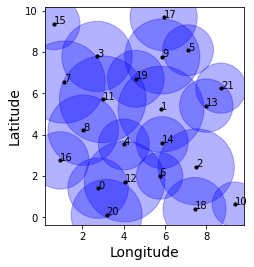

In [3]:
# Save the data of the cameras in a Pandas Dataframe

xs = [a*x[0] for x in sequence][:N]
ys = [a*x[1] for x in sequence][:N]

d = {'id': np.arange(N, dtype=int), 
     'x_loc': xs, 
     'y_loc': ys, 
     'radius': radius,
     'area': np.pi*radius**2}
data = pd.DataFrame(data=d)

# plot the sites
plot_antennas(data, status=np.ones((data.shape[0],)))

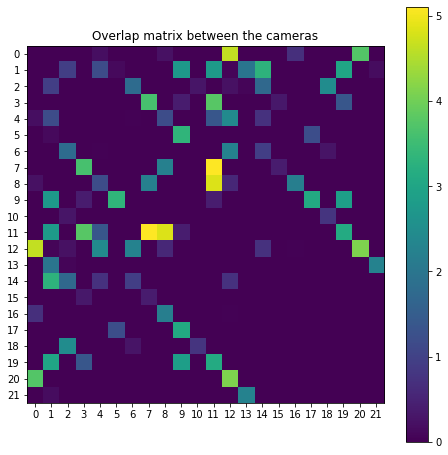

In [4]:
# actual generation of the problem
W, A = generate_problem(data, 0.25, normalize=False)

plt.figure(figsize=(8, 8))
plt.imshow(W)
plt.colorbar()
plt.title("Overlap matrix between the cameras")
N = W.shape[0]
N_r = np.arange(N)
N_t = [str(i) for i in N_r]
_ = plt.xticks(N_r, N_t)
_ = plt.yticks(N_r, N_t)

# Gurobi model

In [5]:
model = gp.Model("Cameras")
J=1

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-21


In [6]:
z = model.addVars(N, vtype=GRB.BINARY, name="z")

In [7]:
# Initialize objective expression
objective = gp.LinExpr()

# Add interaction terms 
for i in range(N):
    for j in range(i+1, N):
        Si = 2 * z[i] - 1
        Sj = 2 * z[j] - 1
        objective += J*W[i][j] * Si * Sj

# Add external field terms
for i in range(N):
    Si = 2 * z[i] - 1
    objective += A[i] * Si

# Set the objective (we are minimizing the Hamiltonian)
model.setObjective(objective, GRB.MINIMIZE)


In [8]:
# Optimize the model
model.optimize()


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 22 columns and 0 nonzeros
Model fingerprint: 0x18293eac
Model has 52 quadratic objective terms
Variable types: 0 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-02, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 131.3428814
Found heuristic solution: objective 45.3182416
Found heuristic solution: objective -55.0929515
Presolve removed 0 rows and 5 columns
Presolve time: 0.01s
Presolved: 41 rows, 58 columns, 123 nonzeros
Variable types: 0 continuous, 58 integer (58 binary)

Root relaxation: objective -8.588280e+01, 27 iterations, 0.00 seconds

In [9]:
# Retrieve results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    spins = []
    for i in range(N):
        if z[i].x == 0:
            spins.append(1)
        if z[i].x == 1:
            spins.append(0)
        # spins.append(z[i].x)
    print("Spins (z):", spins)
    print("Objective Value (Hamiltonian):", model.objVal)
else:
    print("No optimal solution found.")


Optimal solution found:
Spins (z): [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]
Objective Value (Hamiltonian): -55.09295149818706


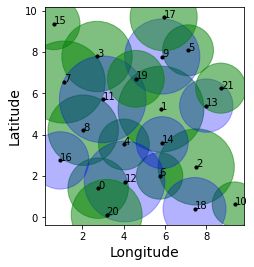

In [10]:
plot_antennas(data, status=spins) #TODO: projective measurements goes inplace of localz

# Constrained Model 

In [59]:
model_constrained = gp.Model("Cameras_constrained")
J=1

z = model_constrained.addVars(N, vtype=GRB.BINARY, name="z")

objective_constr = gp.LinExpr()

for i, j in combinations(range(N),2):
        Si = 2 * z[i] - 1
        Sj = 2 * z[j] - 1
        objective_constr += J*W[i][j] * Si * Sj

# Add external field terms (summation over i)
for i in range(N):
    Si = 2 * z[i] - 1
    objective_constr += A[i] * Si
   

model_constrained.setObjective(objective_constr, GRB.MINIMIZE)
model_constrained.addConstr(gp.quicksum(z[i] for i in range(N)) == C, "HalfActive")

<gurobi.Constr *Awaiting Model Update*>

In [60]:
# Optimize the model
model_constrained.optimize()


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 22 columns and 22 nonzeros
Model fingerprint: 0xd378ca7e
Model has 52 quadratic objective terms
Variable types: 0 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-02, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective -32.9358601
Presolve time: 0.00s
Presolved: 53 rows, 74 columns, 178 nonzeros
Variable types: 0 continuous, 74 integer (74 binary)

Root relaxation: objective -8.833056e+01, 34 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Inc

In [61]:
# Retrieve results
if model_constrained.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    spins = []
    for i in range(N):
        if z[i].x == 0:
            spins.append(1)
        if z[i].x == 1:
            spins.append(0)
        # spins.append(z[i].x)
    print("Spins (z):", spins)
    print("Objective Value (Hamiltonian):", model_constrained.objVal)
else:
    print("No optimal solution found.")


Optimal solution found:
Spins (z): [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]
Objective Value (Hamiltonian): -49.28263938629158


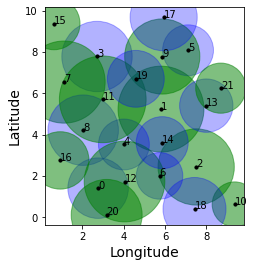

In [62]:
plot_antennas(data, status=spins) #TODO: projective measurements goes inplace of localz

# Constrained case - embedding the constraint in W and A matrices

In [63]:
model_constrained2 = gp.Model("Cameras_constrained2")
J=1

z = model_constrained2.addVars(N, vtype=GRB.BINARY, name="z")

Wp, Ap, scaling = number_constraint(W, A, C, P=1.0, N = N, normalize=False) # I pass the C number of cameras

# Initialize objective expression
objective_constr2 = gp.LinExpr()

# Add interaction terms (summation over i < j)
for i in range(N):
    for j in range(i+1, N):
        Si = 2 * z[i] - 1
        Sj = 2 * z[j] - 1
        objective_constr2 += J*Wp[i][j] * Si * Sj

# Add external field terms (summation over i)
for i in range(N):
    Si = 2 * z[i] - 1
    objective_constr2 += Ap[i] * Si  

# Set the objective (we are minimizing the Hamiltonian)
model_constrained2.setObjective(objective_constr2, GRB.MINIMIZE)


In [64]:
# Optimize the model
model_constrained2.optimize()


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 22 columns and 0 nonzeros
Model fingerprint: 0xa3293cf3
Model has 231 quadratic objective terms
Variable types: 0 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [9e+01, 1e+02]
  QObjective range [2e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 593.3428814
Found heuristic solution: objective 507.3182416
Found heuristic solution: objective -71.2826394
Presolve time: 0.01s
Presolved: 231 rows, 253 columns, 693 nonzeros
Variable types: 0 continuous, 253 integer (253 binary)

Root relaxation: objective -5.503306e+02, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes   

In [65]:
# Retrieve results
if model_constrained2.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    spins2 = []
    for i in range(N):
        if z[i].x == 0:
            spins2.append(1)
        if z[i].x == 1:
            spins2.append(0)
        # spins.append(z[i].x)
    print("Spins (z):", spins)
    print("Objective Value (Hamiltonian):", model_constrained2.objVal)
else:
    print("No optimal solution found.")


Optimal solution found:
Spins (z): [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]
Objective Value (Hamiltonian): -71.28263938629186


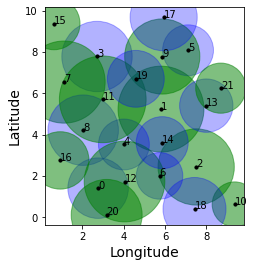

In [66]:
plot_antennas(data, status=spins2) #TODO: projective measurements goes inplace of localz

In [67]:
spins

[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]

In [68]:
spins2

[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0]